<h1 style="text-align: center;">
    <div style="color: #808080; font-size: 60%"> Based onBehavioral Risk Factor Surveillance System  </div>
    <div style="color: #3C8D80"> Public Health Behavior Data Analysis</div>
    <!-- <div style="color: #A569BD;font-size: 40%"> color trying1</div>
    <div style="color: #9B59B6;font-size: 40%"> color trying1</div>
    <div style="color: #8E44AD;font-size: 40%"> color trying1</div> -->
    <div style="font-size: 60%;"><a href="https://idph.illinois.gov/brfss/default.asp">https://idph.illinois.gov/brfss/default.asp</a></div>

<hr style="color: #2F5D62">

# Introduction

This project explores behavioral patterns associated with marijuana use among adults in Illinois using the 2023 Behavioral Risk Factor Surveillance System (BRFSS) microdata.

## Objective
To investigate whether recent marijuana use is linked to:
- Poorer reported mental health
- Increased likelihood of smoking
- Increased probability of drinking

By analyzing co-occurrence of these behaviors, the project aims to highlight potential clusters of health risks that may benefit from targeted public health interventions.

## Tools & Data

- **Dataset**: 2023 Illinois BRFSS (CDC .XPT format)
- **Language**: Python (pandas, seaborn, matplotlib)
- **Key Variables**:
  - `USEMRJN4`: Marijuana use in past 30 days  
  - `MENTHLTH`: Days with poor mental health  
  - `SMOKE100`, `_SMOKER3`: Smoking history and status  
  - `ALC_DAYS`: Days alcohol was consumed  

## Research Relevance

Understanding patterns of marijuana use in the context of mental and behavioral health is critical for shaping community health outreach, especially after legalization. The findings may support more data-informed, age-targeted, or behavior-specific prevention strategies.

### Step 1: Load the Dataset

The dataset used in this project is `LLCP2023.XPT`, the 2023 Illinois Behavioral Risk Factor Surveillance System (BRFSS) file, downloaded from the [https://idph.illinois.gov/brfss/default.asp](https://idph.illinois.gov/brfss/default.asp).  
After importing the dataset, I conducted an initial scan of column names and variable encodings to identify the relevant fields for analysis.

In [18]:
import pyreadstat
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = pd.read_sas("LLCP2023.XPT ", format='xport', encoding='latin1')
df.columns.tolist()


['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'DISPCODE',
 'SEQNO',
 '_PSU',
 'CTELENM1',
 'PVTRESD1',
 'COLGHOUS',
 'STATERE1',
 'CELPHON1',
 'LADULT1',
 'NUMADULT',
 'RESPSLC1',
 'LANDSEX2',
 'LNDSXBRT',
 'SAFETIME',
 'CTELNUM1',
 'CELLFON5',
 'CADULT1',
 'CELLSEX2',
 'CELSXBRT',
 'PVTRESD3',
 'CCLGHOUS',
 'CSTATE1',
 'LANDLINE',
 'HHADULT',
 'SEXVAR',
 'GENHLTH',
 'PHYSHLTH',
 'MENTHLTH',
 'POORHLTH',
 'PRIMINS1',
 'PERSDOC3',
 'MEDCOST1',
 'CHECKUP1',
 'EXERANY2',
 'EXRACT12',
 'EXEROFT1',
 'EXERHMM1',
 'EXRACT22',
 'EXEROFT2',
 'EXERHMM2',
 'STRENGTH',
 'BPHIGH6',
 'BPMEDS1',
 'CHOLCHK3',
 'TOLDHI3',
 'CHOLMED3',
 'CVDINFR4',
 'CVDCRHD4',
 'CVDSTRK3',
 'ASTHMA3',
 'ASTHNOW',
 'CHCSCNC1',
 'CHCOCNC1',
 'CHCCOPD3',
 'ADDEPEV3',
 'CHCKDNY2',
 'HAVARTH4',
 'DIABETE4',
 'DIABAGE4',
 'MARITAL',
 'EDUCA',
 'RENTHOM1',
 'NUMHHOL4',
 'NUMPHON4',
 'CPDEMO1C',
 'VETERAN3',
 'EMPLOY1',
 'CHILDREN',
 'INCOME3',
 'PREGNANT',
 'WEIGHT2',
 'HEIGHT3',
 'DEAF',
 'BLIND',
 'DECIDE',

### Step 2: Select and Prepare Key Variables

To focus on the research question, I selected a subset of columns closely related to marijuana use, mental health, smoking behavior, and alcohol consumption. During preprocessing, I cleaned and recoded values to enhance interpretability and facilitate analysis.

First, find the targeting columns

In [19]:
[col for col in df.columns if "MRJ" in col.upper()]

['USEMRJN4']

In [20]:
[col for col in df.columns if "MENT" in col.upper()]

['MENTHLTH', 'MENTCIGS', 'MENTECIG', '_MENT14D']

In [21]:
[col for col in df.columns if "SMOKE" in col.upper()]

['SMOKE100', '_SMOKER3']

In [22]:
[col for col in df.columns if "ALC" in col.upper()]

['ALCDAY4', '_DUALCOR']

In [23]:
[col for col in df.columns if "AGE" in col.upper()]

['DIABAGE4', 'CNCRAGE', 'CAGEG', '_AGEG5YR', '_AGE65YR', '_AGE80', '_AGE_G']

Then, I examined the content of selected columns more closely and applied initial cleaning steps to improve clarity and make the data more usable for analysis.

#### (a) Age Variable

I selected and formatted `_AGEG5YR`, which groups participants into standard 5-year age bands, making it suitable for demographic segmentation.

In [24]:
age_map = {
    1.0: "18-24",
    2.0: "25-34",
    3.0: "35-44",
    4.0: "45-54",
    5.0: "55-64",
    6.0: "65+"
}

df["AGE_GROUP"] = df["_AGE_G"].map(age_map)
df['AGE_GROUP']


0           65+
1           65+
2           65+
3           65+
4           65+
          ...  
433318      65+
433319    25-34
433320    45-54
433321      65+
433322    45-54
Name: AGE_GROUP, Length: 433323, dtype: object

#### (b) Alcohol Consumption
The `ALC_DAYS` variable represents the number of days a respondent consumed alcohol in the past 30 days. I filtered out special codes and retained only valid numeric responses for comparison.

In [25]:
# switch the code into how many times people would drink within 30 days
def alcday5_to_days(x):
    if x in range(101, 108):  # everyday
        return 30
    elif x in range(201, 208):  # how many times every week
        return (x - 200) * 4  
    elif x in range(301, 331):  # how many times every month
        return x - 300
    elif x == 888:  # never
        return 0
    else:
        return None  # invalid value

df["ALC_DAYS"] = df["ALCDAY4"].apply(alcday5_to_days)


After those basic changes of the columns, we deal with missing data entry and invalid data and gather those columns that we'll mainly use.

In [26]:
df_clean = df[
    (df["USEMRJN4"].isin([1, 2])) &
    (df["MENTHLTH"] <= 30) &
    (df["SMOKE100"].isin([1, 2, 3])) &
    (df["_SMOKER3"] <= 3) &
    ((df["ALC_DAYS"].notna()))
]

# remain_rows = len(df_clean)
df_clean

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV,AGE_GROUP,ALC_DAYS
48140,9.0,2.0,02222023,02,22,2023,1100.0,2023000118,2.023000e+09,1.0,...,5.000000e+02,1.0,1.0,1.0,2.0,1.0,1.0,2.0,65+,30.0
48290,9.0,10.0,12052023,12,05,2023,1100.0,2023000268,2.023000e+09,1.0,...,5.397605e-79,1.0,2.0,2.0,1.0,1.0,1.0,9.0,65+,0.0
48336,9.0,11.0,12072023,12,07,2023,1100.0,2023000314,2.023000e+09,1.0,...,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0,35-44,0.0
49263,9.0,1.0,02242023,02,24,2023,1100.0,2023001231,2.023001e+09,NaN,...,6.000000e+02,1.0,NaN,NaN,1.0,2.0,2.0,2.0,25-34,30.0
49278,9.0,1.0,02282023,02,28,2023,1100.0,2023001246,2.023001e+09,NaN,...,4.700000e+01,1.0,NaN,NaN,1.0,1.0,1.0,2.0,55-64,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432069,78.0,5.0,07072023,07,07,2023,1100.0,2023000815,2.023001e+09,NaN,...,5.397605e-79,1.0,NaN,NaN,1.0,1.0,2.0,9.0,35-44,0.0
432166,78.0,5.0,07062023,07,06,2023,1100.0,2023000912,2.023001e+09,NaN,...,3.270000e+02,1.0,NaN,NaN,1.0,1.0,1.0,2.0,45-54,28.0
432878,78.0,10.0,11212023,11,21,2023,1100.0,2023001624,2.023002e+09,NaN,...,2.300000e+01,1.0,2.0,2.0,1.0,1.0,1.0,2.0,65+,4.0
432921,78.0,10.0,11162023,11,16,2023,1100.0,2023001667,2.023002e+09,NaN,...,1.000000e+03,1.0,NaN,NaN,1.0,2.0,2.0,2.0,45-54,30.0


In [27]:
columns = ["USEMRJN4", "MENTHLTH", "SMOKE100", "_SMOKER3", "ALC_DAYS", "AGE_GROUP"]
df_clean = df_clean[columns]
df_clean

,USEMRJN4,MENTHLTH,SMOKE100,_SMOKER3,ALC_DAYS,AGE_GROUP
48140,1.0,2.0,1.0,3.0,30.0,65+
48290,2.0,10.0,1.0,3.0,0.0,65+
48336,2.0,2.0,1.0,3.0,0.0,35-44
49263,1.0,4.0,1.0,3.0,30.0,25-34
49278,1.0,20.0,1.0,3.0,4.0,55-64
...,...,...,...,...,...,...
432069,1.0,30.0,1.0,3.0,0.0,35-44
432166,1.0,2.0,1.0,3.0,28.0,45-54
432878,1.0,7.0,1.0,3.0,4.0,65+
432921,1.0,9.0,1.0,2.0,30.0,45-54


In [28]:
df_clean.loc[:, "UsedMJ"] = df_clean["USEMRJN4"].apply(lambda x: "Yes" if x == 1 else "No")
grouped = df_clean.groupby("UsedMJ")["MENTHLTH"].mean()
grouped

UsedMJ
No     12.645418
Yes    14.475798
Name: MENTHLTH, dtype: float64

### Step 3: Visualization and Behavioral Comparison

Using the cleaned dataset, I generated visualizations aligned with the project's research focus. Each chart highlights a specific relationship:

- Marijuana use vs. average days of poor mental health  
- Marijuana use vs. smoking history and status (stacked column)  
- Marijuana use vs. alcohol consumption frequency  
- Age distribution of marijuana users

These figures support initial insights into potential behavioral clustering around marijuana use.


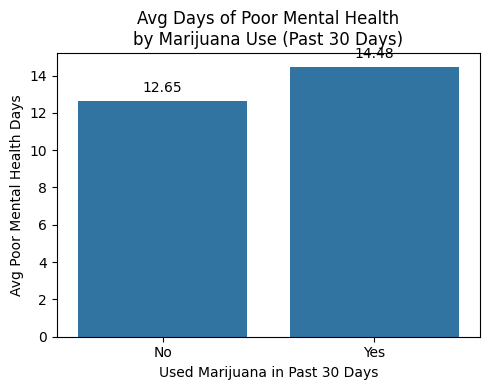

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 4))
ax = sns.barplot(x=grouped.index, y=grouped.values)
for i, v in enumerate(grouped.values):
    ax.text(i, v + 0.3, f"{v:.2f}", ha='center', va='bottom')
    
plt.title("Avg Days of Poor Mental Health\nby Marijuana Use (Past 30 Days)")
plt.xlabel("Used Marijuana in Past 30 Days")
plt.ylabel("Avg Poor Mental Health Days")
plt.tight_layout()
plt.show()

In [30]:
def smoker_status(x):
    if x == 1 or x == 2:
        return "Current Smoker"
    elif x == 3:
        return "Non-Smoker"
    else:
        return "Other"

df_clean.loc[:, "SmokerStatus"] = df_clean["_SMOKER3"].apply(smoker_status)
crosstab = pd.crosstab(df_clean["UsedMJ"], df_clean["SmokerStatus"], normalize='index')
crosstab

SmokerStatus,Current Smoker,Non-Smoker
UsedMJ,,
No,0.302789,0.697211
Yes,0.490216,0.509784


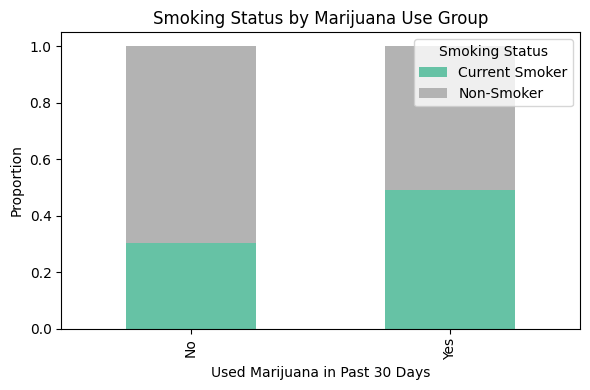

In [31]:
crosstab.plot(kind="bar", stacked=True, figsize=(6, 4), colormap="Set2")
plt.title("Smoking Status by Marijuana Use Group")
plt.xlabel("Used Marijuana in Past 30 Days")
plt.ylabel("Proportion")
plt.legend(title="Smoking Status")
plt.tight_layout()
plt.show()

/var/folders/p6/wz4w_h550d50qf_ycfmy2qj80000gn/T/ipykernel_71632/3625345591.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alc_by_group.index, y=alc_by_group.values, palette="Greens_d")


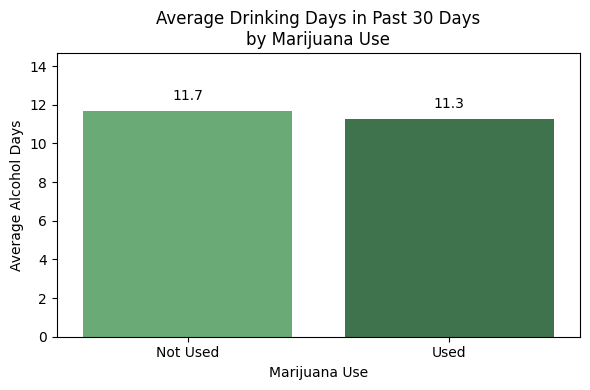

In [32]:
df_clean.loc[:, "Marijuana_Use"] = df_clean["USEMRJN4"].map({1: "Used", 2: "Not Used"})
alc_by_group = df_clean.groupby("Marijuana_Use")["ALC_DAYS"].mean()

plt.figure(figsize=(6, 4))
sns.barplot(x=alc_by_group.index, y=alc_by_group.values, palette="Greens_d")

for i, val in enumerate(alc_by_group.values):
    plt.text(i, val + 0.4, f"{val:.1f}", ha="center", va="bottom", fontsize=10)

plt.title("Average Drinking Days in Past 30 Days\nby Marijuana Use")
plt.xlabel("Marijuana Use")
plt.ylabel("Average Alcohol Days")
plt.ylim(0, max(alc_by_group.values) + 3)
plt.tight_layout()
plt.show()

In [33]:
marijuana_rate_by_age = df_clean.groupby("AGE_GROUP")["USEMRJN4"].apply(lambda x: (x == 1).mean()).reset_index(name="Marijuana Use Rate")
marijuana_rate_by_age

,AGE_GROUP,Marijuana Use Rate
0,18-24,0.880435
1,25-34,0.851406
2,35-44,0.801829
3,45-54,0.744000
4,55-64,0.787879
5,65+,0.695238


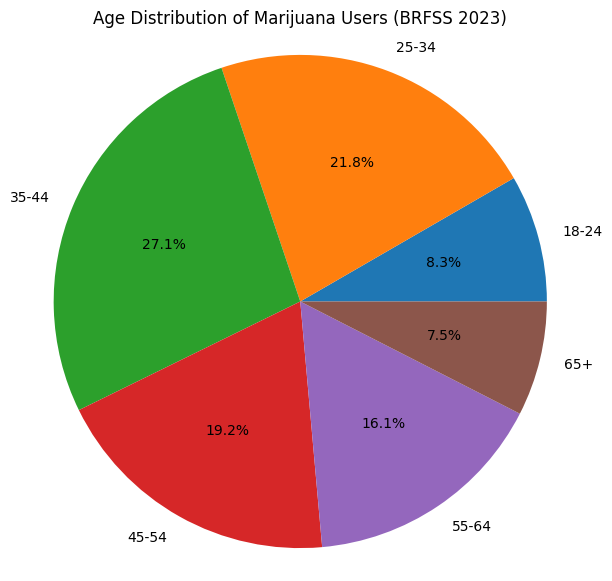

In [34]:
mj_users = df_clean[df_clean["USEMRJN4"] == 1]

age_counts = mj_users["AGE_GROUP"].value_counts().sort_index()

plt.figure(figsize=(7, 7))
plt.pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
plt.title("Age Distribution of Marijuana Users (BRFSS 2023)")
plt.axis('equal') 
plt.show()

### Conclusion

This project examined the relationship between marijuana use and several co-occurring health behaviors among Illinois adults using the 2023 BRFSS dataset.

Key findings include:

- **Mental Health**: Respondents who reported marijuana use in the past 30 days also reported a higher average number of poor mental health days.
- **Smoking**: Marijuana users were more likely to have a history of smoking or be current smokers.
- **Alcohol Use**: Interestingly, individuals who did **not** use marijuana reported drinking **slightly more often** (11.7 days) than those who did use marijuana (11.3 days). The difference, however, is minimal and may not be statistically significant.
- **Age Distribution**: Usage was more prevalent among younger adults, particularly those aged 25–44.

These findings suggest that marijuana use frequently co-occurs with other health risk behaviors, especially smoking and mental distress, which has implications for designing integrated public health interventions targeting mental health, substance use, and youth behavior.

However, the finding regarding alcohol use diverges from expectations. Unlike smoking and mental health, alcohol consumption did not show a strong association with marijuana use in this dataset. Additional analyses—especially statistical testing or multivariate modeling—may clarify whether this pattern holds in broader or more specific subpopulations.

Future directions should include longitudinal analysis to better assess causal pathways, and integration with demographic and regional context from ACS data to inform more targeted, evidence-based health strategies.


